<a href="https://colab.research.google.com/github/dasamitansu159/Physic-Informed-Neural-Networks/blob/main/Burgers_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn

In [ ]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, depth, act):
        super(NN, self).__init__()
        self.layers = [nn.Linear(input_size, hidden_size), act()]
        for _ in range(depth - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(act())
        self.layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)

        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 2 + self.k, self.k)

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

        # training data
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=100000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",   # better numerical stability
        )

        self.adam = torch.optim.Adam(self.model.parameters())

    def loss_func(self):
        # this is more like a not so elegant hack to zero grad both optimizers
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            inputs=self.X,
            outputs=u,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
            inputs=self.X,
            outputs=du_dX,
            grad_outputs=torch.ones_like(du_dX),
            retain_graph=True,
            create_graph=True
        )[0][:, 0]

        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 / math.pi * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 10000 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss

    def train(self):
        self.model.train()
        for i in range(40000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()


In [ ]:
net = Net()
net.train()

10000 0.0009941324824467301
20000 0.0003011983644682914
30000 9.897444397211075e-05
40000 5.7085017033386976e-05


In [ ]:
import scipy.io

data = scipy.io.loadmat('burgers_shock.mat')
usol = data["usol"]
x_star = data['x']
t_star = data["t"]

In [ ]:
# net.eval_()
net.model.eval()

x = torch.tensor(x_star.squeeze(),dtype=torch.float32)
t = torch.tensor(t_star.squeeze(),dtype=torch.float32)


X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

X = X.to(net.X.device)

In [ ]:
model = net.model
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

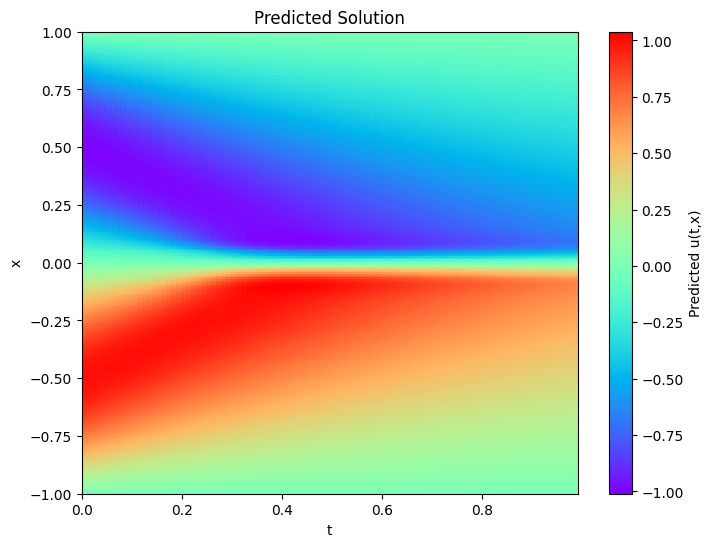

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

im1 = ax.imshow(
    y_pred,
    interpolation="nearest",
    cmap="rainbow",
    extent=(np.min(t_star), np.max(t_star), np.min(x_star), np.max(x_star)),
    origin="lower",
    aspect="auto",
)
cbar= fig.colorbar(im1, ax=ax)
cbar.set_label("Predicted u(t,x)")
ax.set_title("Predicted Solution")
ax.set_ylabel("x")
ax.set_xlabel("t")

fig.savefig("Predticted")
plt.show()

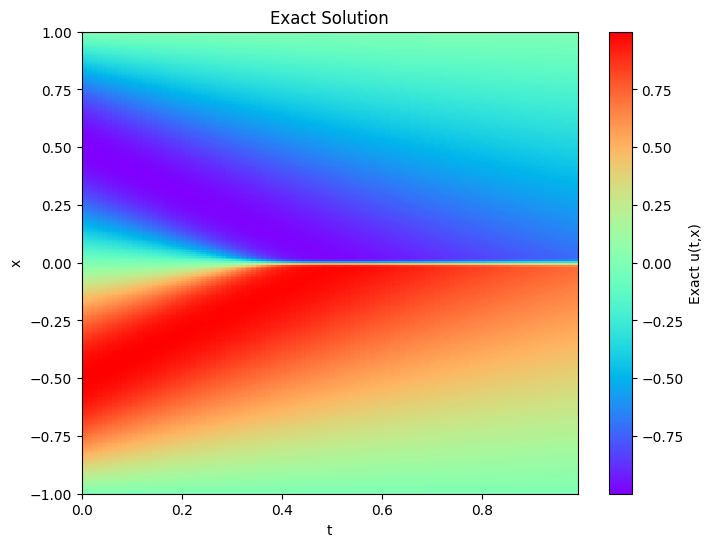

In [ ]:
# Plot predictions
fig, ax = plt.subplots(figsize=(8, 6))

im1 = ax.imshow(
    usol,
    interpolation="nearest",
    cmap="rainbow",
    extent=(np.min(t_star), np.max(t_star), np.min(x_star), np.max(x_star)),
    origin="lower",
    aspect="auto",
)
cbar = fig.colorbar(im1, ax=ax)
cbar.set_label("Exact u(t,x)")
ax.set_title("Exact Solution")
ax.set_ylabel("x")
ax.set_xlabel("t")
fig.savefig("Exact")
plt.show()

In [ ]:
print(f"Absolute Error: {np.mean(y_pred - usol)}")

Absolute Error: -0.00015062046237354344


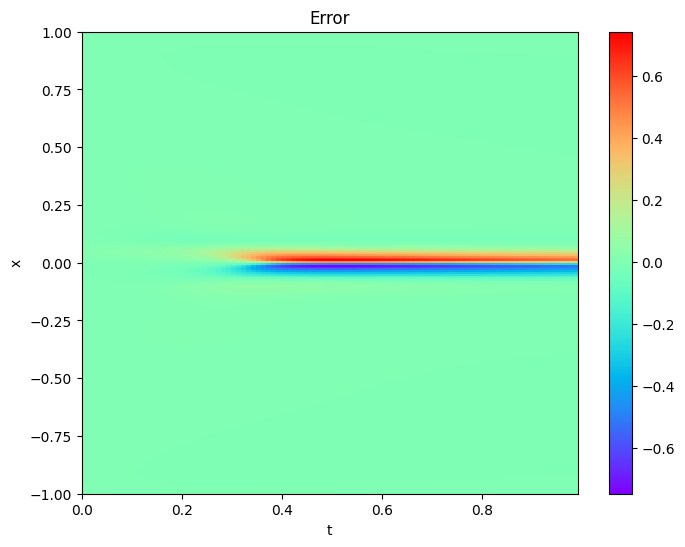

In [ ]:
# Plot predictions
fig, ax = plt.subplots(figsize=(8, 6))

im1 = ax.imshow(
    y_pred - usol,
    interpolation="nearest",
    cmap="rainbow",
    extent=(np.min(t_star), np.max(t_star), np.min(x_star), np.max(x_star)),
    origin="lower",
    aspect="auto",
)
fig.colorbar(im1, ax=ax)
ax.set_title("Error")
ax.set_ylabel("x")
ax.set_xlabel("t")
fig.savefig("Error")
plt.show()

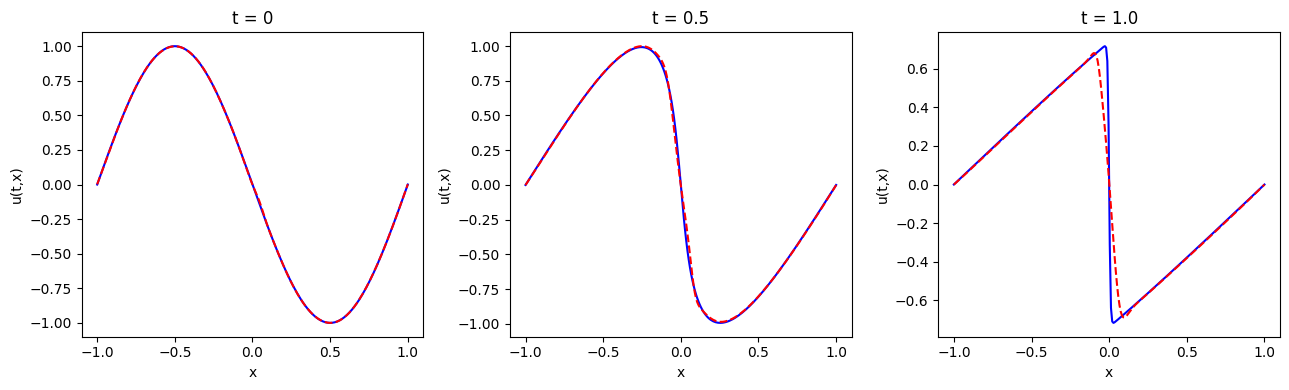

In [ ]:
fig = plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.plot(x_star, usol[:,0], color='blue')
plt.plot(x_star, y_pred[:,0], '--', color='red')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('t = 0')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(x_star, usol[:,25], color='blue')
plt.plot(x_star, y_pred[:,25], '--', color='red')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('t = 0.5')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(x_star, usol[:,-1], color='blue')
plt.plot(x_star, y_pred[:,-1], '--', color='red')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('t = 1.0')
plt.tight_layout()
plt.savefig("2")
plt.show()

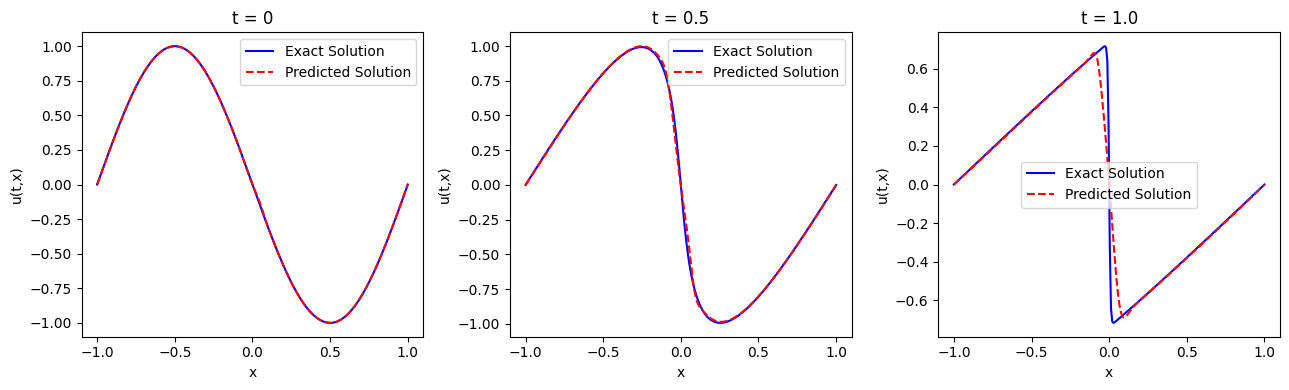

In [ ]:
fig = plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.plot(x_star, usol[:, 0], color='blue', label='Exact Solution')
plt.plot(x_star, y_pred[:, 0], '--', color='red', label='Predicted Solution')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('t = 0')
plt.legend()
plt.tight_layout()

# Second subplot
plt.subplot(1, 3, 2)
plt.plot(x_star, usol[:, 25], color='blue', label='Exact Solution')
plt.plot(x_star, y_pred[:, 25], '--', color='red', label='Predicted Solution')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('t = 0.5')
plt.legend()
plt.tight_layout()

# Third subplot
plt.subplot(1, 3, 3)
plt.plot(x_star, usol[:, -1], color='blue', label='Exact Solution')
plt.plot(x_star, y_pred[:, -1], '--', color='red', label='Predicted Solution')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('t = 1.0')
plt.legend()
plt.tight_layout()
plt.savefig("2")
plt.show()